In [1]:
MODELS_FROM_FILE = 0
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_w_imp.columns if x.startswith("WIAT") or x.startswith("WISC")] # All WISC and WIAT columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC

# Separate test set for all output columns

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [2]:
#display(train_set[input_cols].describe())
display(train_set[output_cols].describe())
#train_set[input_cols].dtypes.value_counts()
#train_set[output_cols].dtypes.value_counts()
print("Before imputation")
print("nan x", np.any(np.isnan(train_set[input_cols])))
print("inf x", np.all(np.isfinite(train_set[input_cols])))
print("nan y", np.any(np.isnan(train_set[output_cols])))
print("inf y", np.all(np.isfinite(train_set[output_cols])))

#cross_val_score(make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), ElasticNet()), train_set[input_cols], train_set[output_cols] )
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
x_imputed = imputer.fit_transform(train_set[input_cols])
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_imputed)
model = ElasticNet()
#model.fit(x_imputed, train_set[output_cols])
print("After imputation")
print("nan x", np.any(np.isnan(x_imputed)))
print("inf x", np.all(np.isfinite(x_imputed)))
df_describe = pd.DataFrame(x_imputed)
#df_describe.describe()
#df_describe[np.isfinite(df_describe)]

,"WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd","WISC,WISC_Coding_Scaled","WISC,WISC_FSIQ","WISC,WISC_SS_Scaled"
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,99.783576,102.378358,8.771297,99.977744,9.555641
std,17.740945,16.907730,3.179940,16.241371,3.092247
min,53.000000,41.000000,1.000000,51.000000,1.000000
25%,88.000000,91.000000,7.000000,87.500000,7.000000
50%,99.000000,105.000000,9.000000,101.000000,10.000000
75%,110.000000,114.000000,11.000000,110.000000,11.000000
max,160.000000,153.000000,19.000000,147.000000,19.000000


Before imputation
nan x True
inf x False
nan y False
inf y True
After imputation
nan x False
inf x True


In [3]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth' : np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    return (best_estimator, best_score)

In [4]:
def find_best_estimator_for_output(output_col):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, output_col)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [5]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.330e+03, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+02, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.782e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.967e+03, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.223e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.162e+03, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.715e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e+02, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.149e+01, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.419e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.248e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.173e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.327e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WIAT,WIAT_Num_Stnd :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=44, max_features=0.5,
                                       min_samples_leaf=6, min_samples_split=5,
                                       n_estimators=299))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.220e+02, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.579e+02, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.288e+02, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e+03, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.870e+01, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.249e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.356e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.743e+02, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.731e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.583e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WIAT,WIAT_Word_Stnd :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=1.2242279579331625,
                            l1_ratio=0.25422382033019764))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e+02, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+00, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e+02, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+02, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+00, tolerance: 8.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+02, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+02, tolerance: 8.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WISC,WISC_Coding_Scaled :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.30789860200132757,
                            l1_ratio=0.40127409844233664))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.351e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.846e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.467e+02, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e+03, tolerance: 2.316e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.733e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+03, tolerance: 2.316e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.586e+01, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WISC,WISC_FSIQ :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.4194460917636233,
                            l1_ratio=0.819934914763971))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+01, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e+02, tolerance: 8.455e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+02, tolerance: 8.455e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e+00, tolerance: 8.335e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e+00, tolerance: 8.455e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e+02, tolerance: 8.335e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WISC,WISC_SS_Scaled :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=30, min_samples_leaf=10,
                                       min_samples_split=5, n_estimators=74))])


In [6]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("data/output/best-estimators-cog-scores-item-lvl.csv")

    dump(best_estimators, 'best-estimators-cog-scores-item-lvl.joblib', compress=1)

Output  \
0       WIAT,WIAT_Num_Stnd   
1      WIAT,WIAT_Word_Stnd   
2  WISC,WISC_Coding_Scaled   
3           WISC,WISC_FSIQ   
4      WISC,WISC_SS_Scaled   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [7]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-cog-scores-item-lvl.joblib')

In [8]:
metric_names = ['r2']   
def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    metrics.append(r2)
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.show()
        
    return metrics

,test_score,train_score
0,0.187899,0.715466
1,0.179276,0.709622
2,0.228462,0.706279
3,0.144722,0.718823
4,0.202110,0.703211


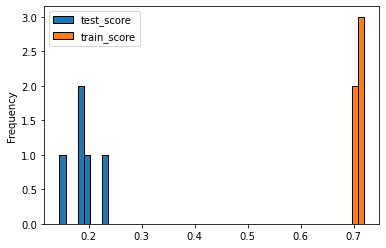

,test_score,train_score
0,0.270664,0.431050
1,0.229457,0.445898
2,0.288343,0.423023
3,0.241413,0.440058
4,0.254964,0.422176


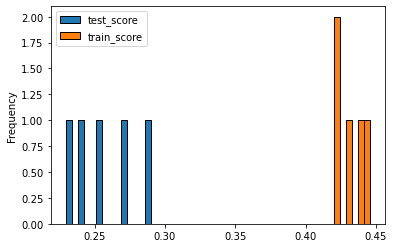

,test_score,train_score
0,0.108579,0.279306
1,0.163389,0.254699
2,0.175395,0.263872
3,0.161775,0.265983
4,0.119756,0.269368


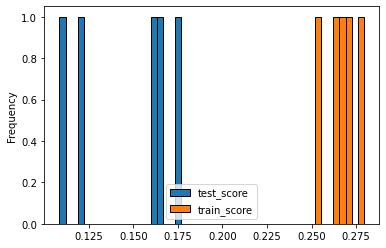

,test_score,train_score
0,0.380689,0.592277
1,0.403496,0.594378
2,0.418115,0.584437
3,0.386275,0.589234
4,0.381076,0.584648


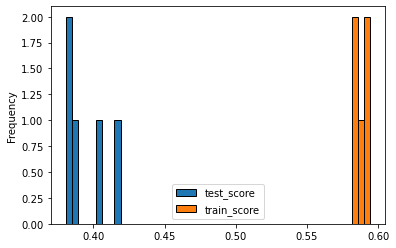

,test_score,train_score
0,0.083702,0.580353
1,0.130437,0.567406
2,0.118437,0.565909
3,0.079164,0.569936
4,0.105979,0.572508


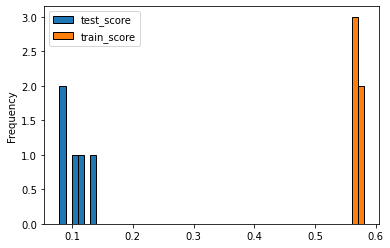

,Output,Mean R2,Std R2
0,"WIAT,WIAT_Num_Stnd",0.188494,0.027511
1,"WIAT,WIAT_Word_Stnd",0.256968,0.020856
2,"WISC,WISC_Coding_Scaled",0.145779,0.026473
3,"WISC,WISC_FSIQ",0.393931,0.014667
4,"WISC,WISC_SS_Scaled",0.103544,0.019693


In [9]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50, edgecolor="black")
    plt.show()

results_val_set = []
for output in output_cols:
    estimator = best_estimators[output]
    cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True)
    metrics = [np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])]
    results_val_set.append([
        output, 
        *metrics])
    
    plot_test_vs_train_scores(cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2"])
restults_val_set_df

WIAT,WIAT_Num_Stnd
r2:  0.19108338532187963


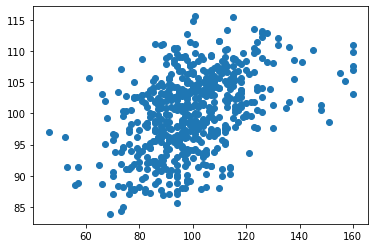

WIAT,WIAT_Word_Stnd
r2:  0.2836837931006312


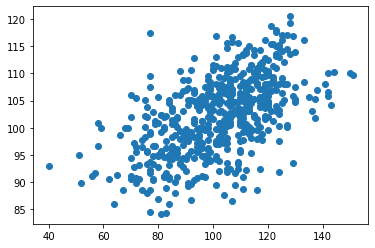

WISC,WISC_Coding_Scaled
r2:  0.16242010382056193


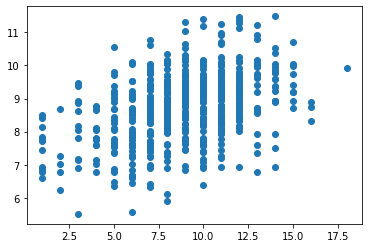

WISC,WISC_FSIQ
r2:  0.44796915366897505


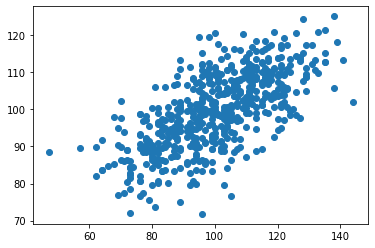

WISC,WISC_SS_Scaled
r2:  0.11778898412018923


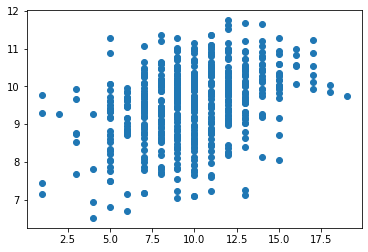

,Output,r2
3,"WISC,WISC_FSIQ",0.447969
1,"WIAT,WIAT_Word_Stnd",0.283684
0,"WIAT,WIAT_Num_Stnd",0.191083
2,"WISC,WISC_Coding_Scaled",0.162420
4,"WISC,WISC_SS_Scaled",0.117789


In [10]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in output_cols:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

### Feature importance

In [11]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

WIAT,WIAT_Num_Stnd


,r2
1,0.097610
2,0.121204
3,0.134819
4,0.162145
5,0.188850
...,...
96,0.245209
97,0.244325
98,0.242586
99,0.244699


Max score:  0.25407687456154165  at  32  features


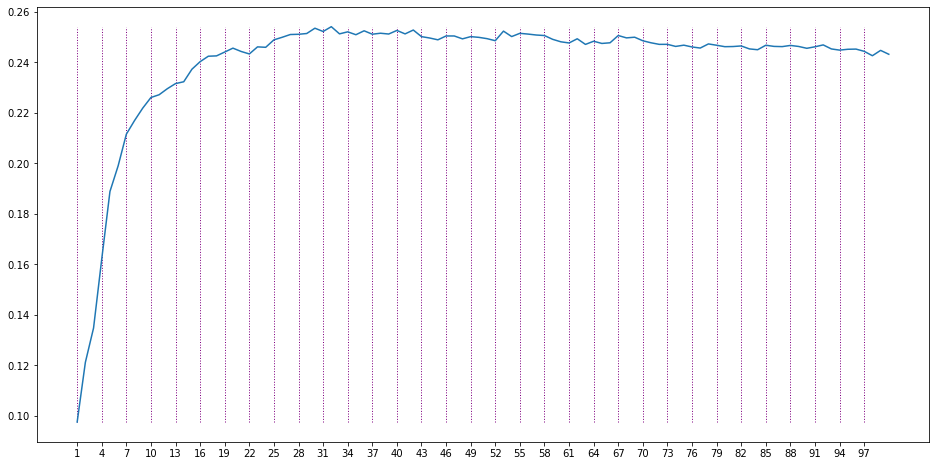

Optimal number of features:  17


('Basic_Demos,Age',
 'SympChck,CSC_50C',
 'SympChck,CSC_55fC',
 'SCQ,SCQ_05',
 'ASSQ,ASSQ_02',
 'SDQ,SDQ_24',
 'SWAN,SWAN_02',
 'CBCL,CBCL_18',
 'CBCL,CBCL_61',
 'CBCL,CBCL_83',
 'APQ_P,APQ_P_23',
 'APQ_P,APQ_P_31',
 'PCIAT,PCIAT_18',
 'APQ_SR,APQ_SR_30',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'APQ_SR,APQ_SR_04A_WAS_MISSING')

WIAT,WIAT_Word_Stnd


,r2
1,0.107884
2,0.130809
3,0.150775
4,0.161551
5,0.175365
...,...
96,0.331437
97,0.331707
98,0.331959
99,0.332220


Max score:  0.3324570662815263  at  100  features


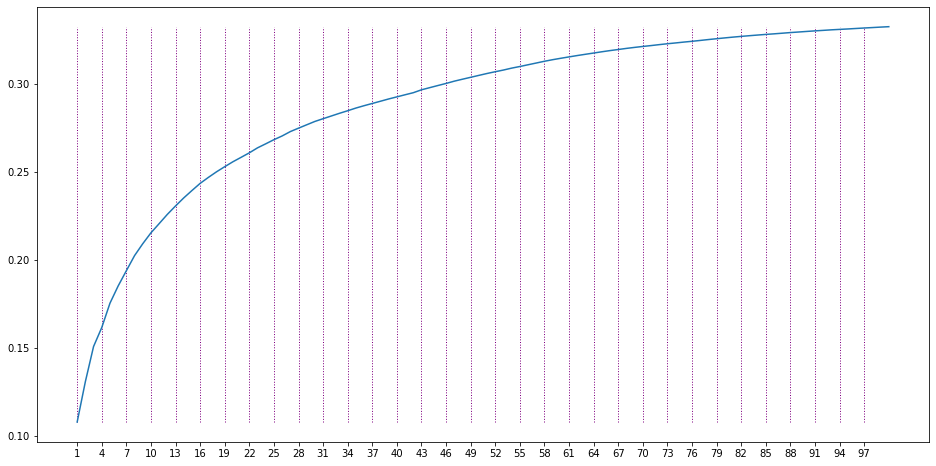

Optimal number of features:  27


('SympChck,CSC_36C',
 'SympChck,CSC_46P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_14',
 'ASSQ,ASSQ_05',
 'SDQ,SDQ_20',
 'SDQ,SDQ_27',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_06',
 'SRS,SRS_14',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'CBCL,CBCL_58',
 'CBCL,CBCL_61',
 'CBCL,CBCL_79',
 'APQ_P,APQ_P_34',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'MFQ_P,MFQ_P_01',
 'APQ_SR,APQ_SR_16',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'PSI,PSI_PD',
 'RBS,RBS_09',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_15A_WAS_MISSING')

WISC,WISC_Coding_Scaled


,r2
1,0.053464
2,0.078587
3,0.102325
4,0.126579
5,0.135891
...,...
96,0.197860
97,0.197860
98,0.197860
99,0.197860


Max score:  0.1978601666140425  at  93  features


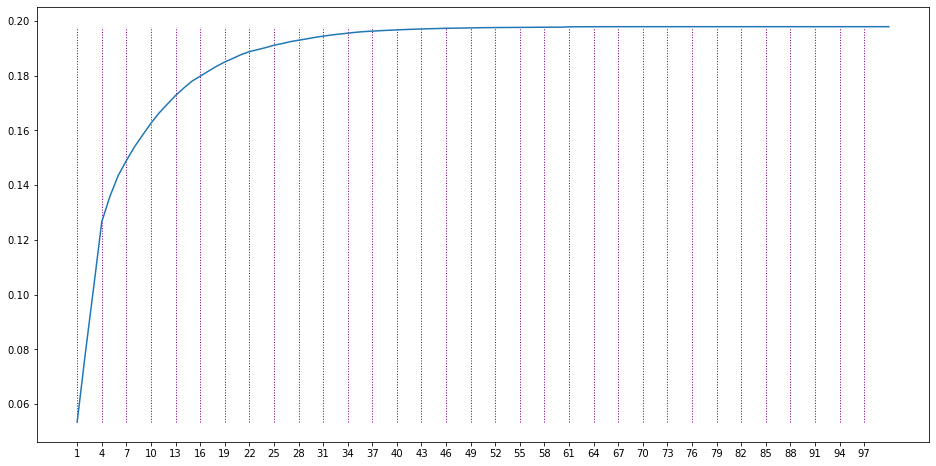

Optimal number of features:  19


('Basic_Demos,Age',
 'Basic_Demos,Sex',
 'SympChck,CSC_06P',
 'ASSQ,ASSQ_01',
 'ASSQ,ASSQ_09',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_21',
 'SRS,SRS_49',
 'CBCL,CBCL_01',
 'CBCL,CBCL_18',
 'CBCL,CBCL_62',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_06',
 'APQ_P,APQ_P_35',
 'APQ_P,APQ_P_40',
 'APQ_SR,APQ_SR_39',
 'PSI,PSI_14',
 'PSI,PSI_18')

WISC,WISC_FSIQ


,r2
1,0.193116
2,0.230600
3,0.261226
4,0.283233
5,0.305038
...,...
96,0.485079
97,0.485184
98,0.485293
99,0.485380


Max score:  0.4854607776673469  at  100  features


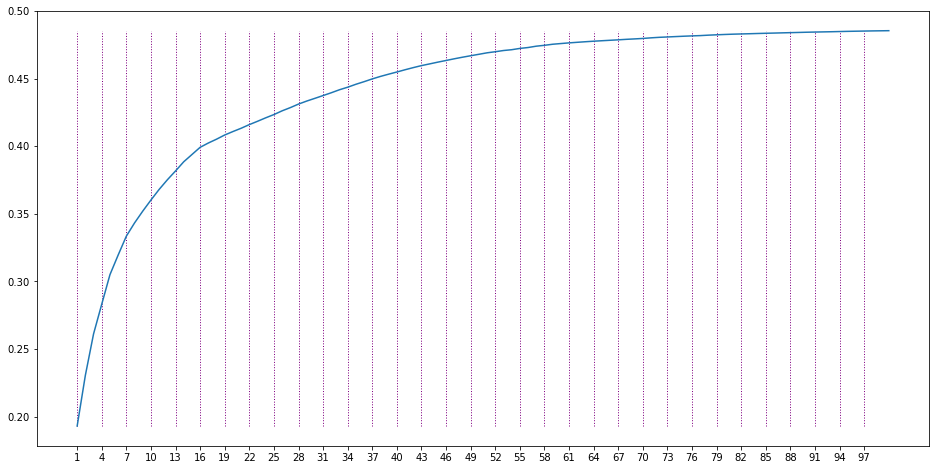

Optimal number of features:  19


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'Barratt,financialsupport',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'APQ_P,APQ_P_18',
 'APQ_P,APQ_P_31',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'ESWAN,MDD_5',
 'APQ_SR,APQ_SR_05',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_02',
 'PSI,PSI_18',
 'PSI,PSI_PD',
 'RBS,RBS_36')

WISC,WISC_SS_Scaled


,r2
1,0.054531
2,0.069017
3,0.080533
4,0.094144
5,0.102131
...,...
96,0.137022
97,0.135828
98,0.139668
99,0.135918


Max score:  0.15530512651868192  at  39  features


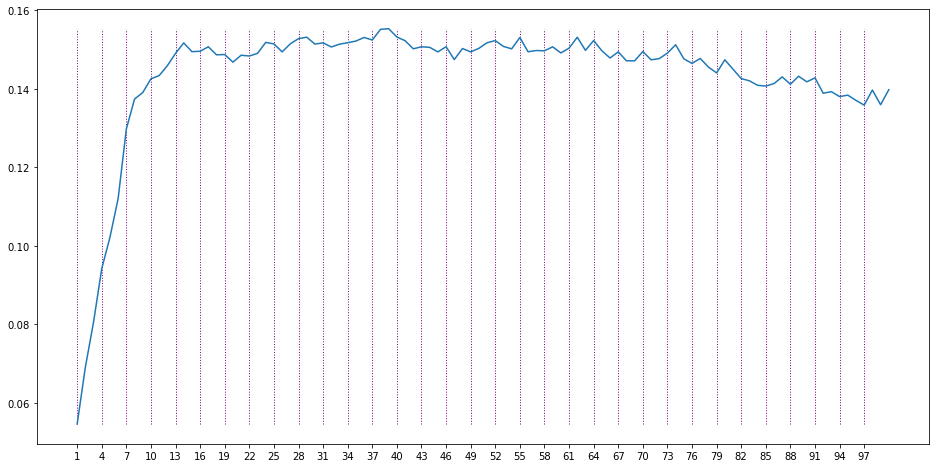

Optimal number of features:  14


('SympChck,CSC_43C',
 'SCQ,SCQ_03',
 'ASSQ,ASSQ_04',
 'CBCL,CBCL_80',
 'APQ_P,APQ_P_31',
 'ESWAN,MDD_3B',
 'ESWAN,Panic_B01',
 'APQ_SR,APQ_SR_34',
 'WHODAS_P,WHODAS_P_09',
 'PSI,PSI_05',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'PSI,PSI_20',
 'RBS,RBS_40')

In [12]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in output_cols:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [13]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-imp-item-lvl.joblib', compress=1)

WIAT,WIAT_Num_Stnd


,r2
1,0.097610
2,0.121204
3,0.134819
4,0.162145
5,0.188850
...,...
96,0.245209
97,0.244325
98,0.242586
99,0.244699


Max score:  0.25407687456154165  at  32  features


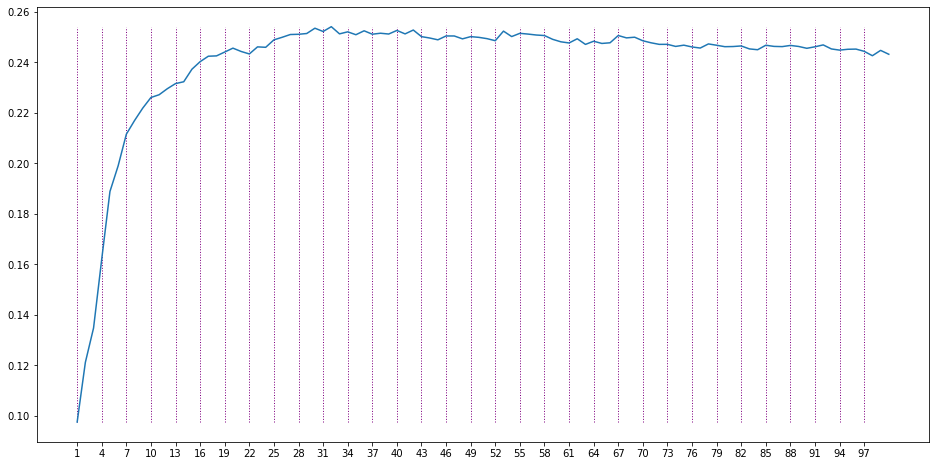

Optimal number of features:  17


('Basic_Demos,Age',
 'SympChck,CSC_50C',
 'SympChck,CSC_55fC',
 'SCQ,SCQ_05',
 'ASSQ,ASSQ_02',
 'SDQ,SDQ_24',
 'SWAN,SWAN_02',
 'CBCL,CBCL_18',
 'CBCL,CBCL_61',
 'CBCL,CBCL_83',
 'APQ_P,APQ_P_23',
 'APQ_P,APQ_P_31',
 'PCIAT,PCIAT_18',
 'APQ_SR,APQ_SR_30',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'APQ_SR,APQ_SR_04A_WAS_MISSING')

Score using all features: 
WIAT,WIAT_Num_Stnd
r2:  0.19604617761755982


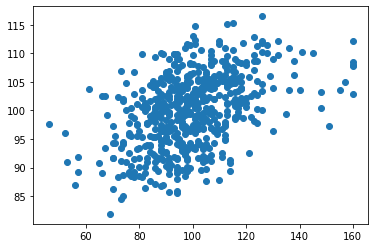

R2:  0.19604617761755982
Performance on test set using optimal number of columns: 
WIAT,WIAT_Num_Stnd
r2:  0.13398990782888975


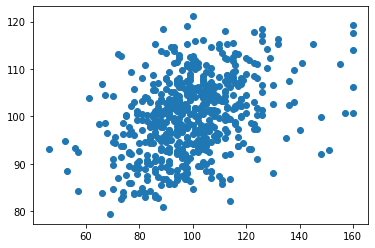

R2:  0.13398990782888975
Performance on test set using number of columns with maximum score
WIAT,WIAT_Num_Stnd
r2:  0.16459920035664977


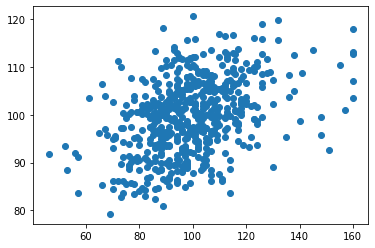

R2:  0.16459920035664977
WIAT,WIAT_Word_Stnd


,r2
1,0.107884
2,0.130809
3,0.150775
4,0.161551
5,0.175365
...,...
96,0.331437
97,0.331707
98,0.331959
99,0.332220


Max score:  0.3324570662815263  at  100  features


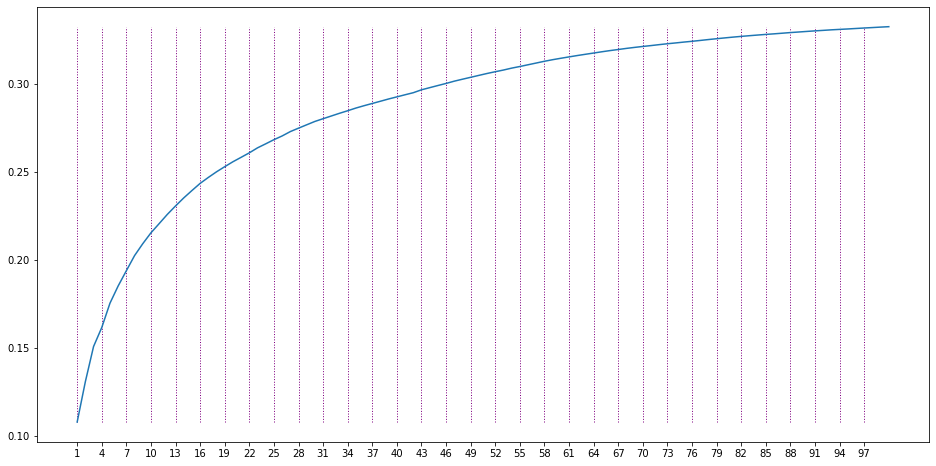

Optimal number of features:  27


('SympChck,CSC_36C',
 'SympChck,CSC_46P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_14',
 'ASSQ,ASSQ_05',
 'SDQ,SDQ_20',
 'SDQ,SDQ_27',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_06',
 'SRS,SRS_14',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'CBCL,CBCL_58',
 'CBCL,CBCL_61',
 'CBCL,CBCL_79',
 'APQ_P,APQ_P_34',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'MFQ_P,MFQ_P_01',
 'APQ_SR,APQ_SR_16',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'PSI,PSI_PD',
 'RBS,RBS_09',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_15A_WAS_MISSING')

Score using all features: 
WIAT,WIAT_Word_Stnd
r2:  0.2836837931006312


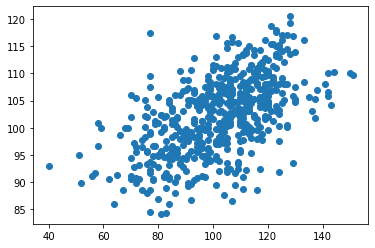

R2:  0.2836837931006312
Performance on test set using optimal number of columns: 
WIAT,WIAT_Word_Stnd
r2:  0.24351819100723582


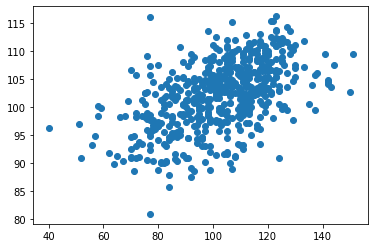

R2:  0.24351819100723582
Performance on test set using number of columns with maximum score
WIAT,WIAT_Word_Stnd
r2:  0.2855668354741757


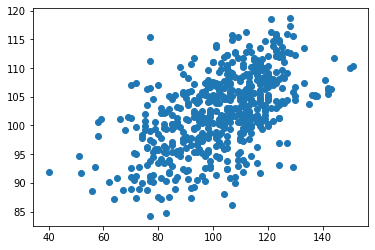

R2:  0.2855668354741757
WISC,WISC_Coding_Scaled


,r2
1,0.053464
2,0.078587
3,0.102325
4,0.126579
5,0.135891
...,...
96,0.197860
97,0.197860
98,0.197860
99,0.197860


Max score:  0.1978601666140425  at  93  features


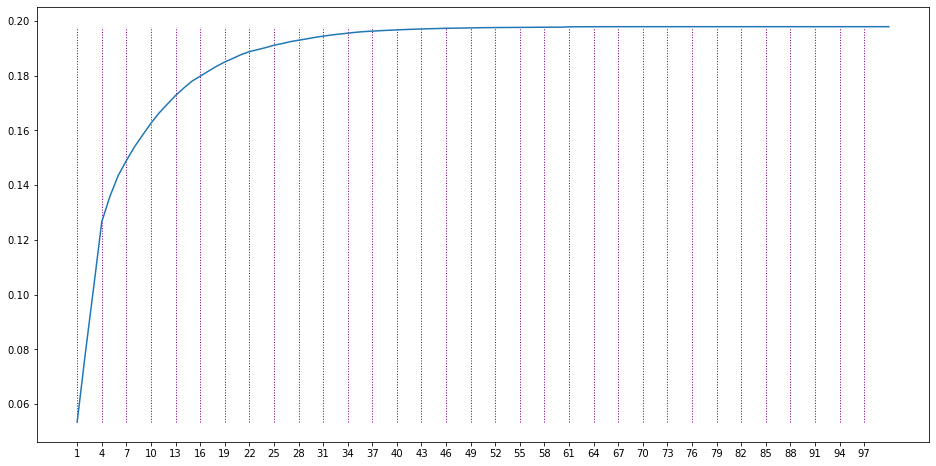

Optimal number of features:  19


('Basic_Demos,Age',
 'Basic_Demos,Sex',
 'SympChck,CSC_06P',
 'ASSQ,ASSQ_01',
 'ASSQ,ASSQ_09',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_21',
 'SRS,SRS_49',
 'CBCL,CBCL_01',
 'CBCL,CBCL_18',
 'CBCL,CBCL_62',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_06',
 'APQ_P,APQ_P_35',
 'APQ_P,APQ_P_40',
 'APQ_SR,APQ_SR_39',
 'PSI,PSI_14',
 'PSI,PSI_18')

Score using all features: 
WISC,WISC_Coding_Scaled
r2:  0.16242010382056193


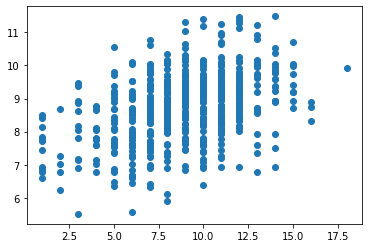

R2:  0.16242010382056193
Performance on test set using optimal number of columns: 
WISC,WISC_Coding_Scaled
r2:  0.13709727298745833


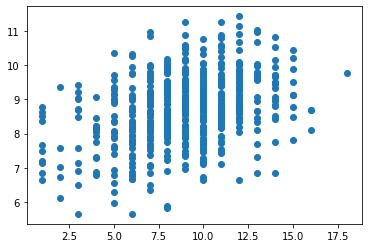

R2:  0.13709727298745833
Performance on test set using number of columns with maximum score
WISC,WISC_Coding_Scaled
r2:  0.15245589327845976


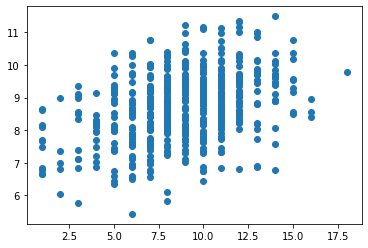

R2:  0.15245589327845976
WISC,WISC_FSIQ


,r2
1,0.193116
2,0.230600
3,0.261226
4,0.283233
5,0.305038
...,...
96,0.485079
97,0.485184
98,0.485293
99,0.485380


Max score:  0.4854607776673469  at  100  features


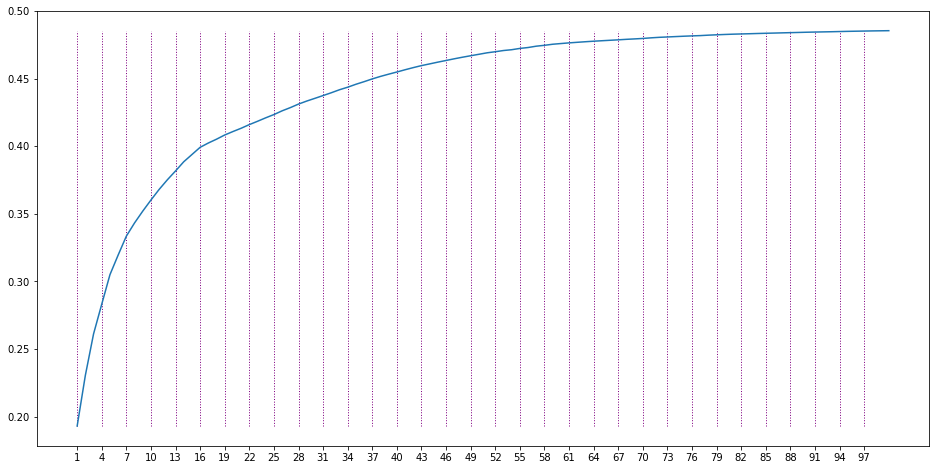

Optimal number of features:  19


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'Barratt,financialsupport',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'APQ_P,APQ_P_18',
 'APQ_P,APQ_P_31',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'ESWAN,MDD_5',
 'APQ_SR,APQ_SR_05',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_02',
 'PSI,PSI_18',
 'PSI,PSI_PD',
 'RBS,RBS_36')

Score using all features: 
WISC,WISC_FSIQ
r2:  0.44796915366897505


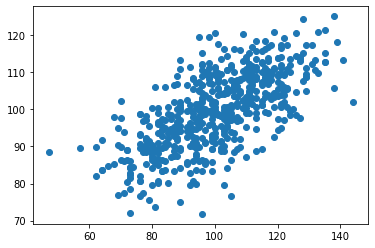

R2:  0.44796915366897505
Performance on test set using optimal number of columns: 
WISC,WISC_FSIQ
r2:  0.3877601218021963


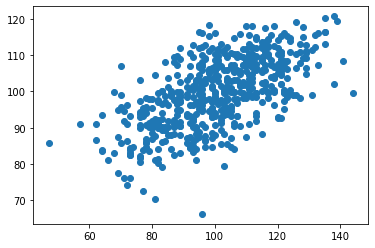

R2:  0.3877601218021963
Performance on test set using number of columns with maximum score
WISC,WISC_FSIQ
r2:  0.4360088577103364


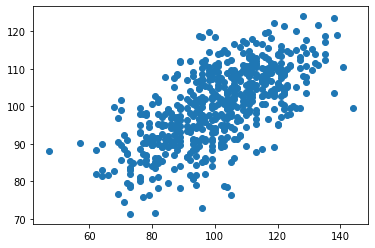

R2:  0.4360088577103364
WISC,WISC_SS_Scaled


,r2
1,0.054531
2,0.069017
3,0.080533
4,0.094144
5,0.102131
...,...
96,0.137022
97,0.135828
98,0.139668
99,0.135918


Max score:  0.15530512651868192  at  39  features


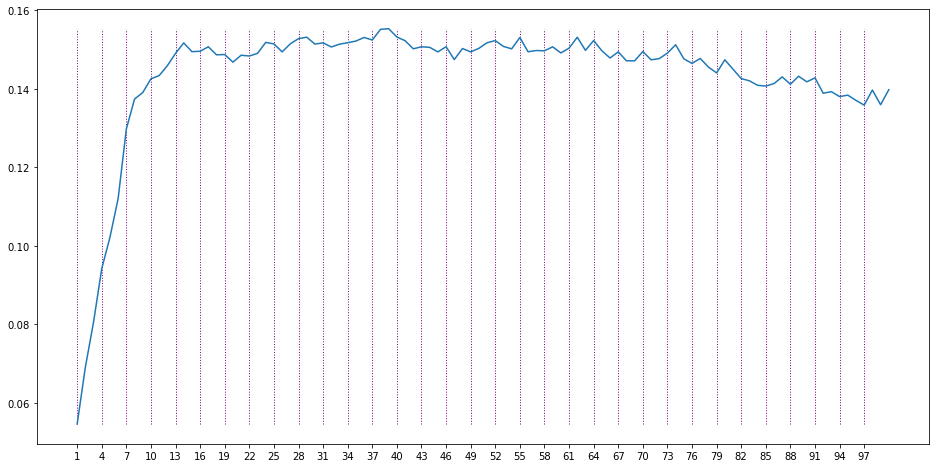

Optimal number of features:  14


('SympChck,CSC_43C',
 'SCQ,SCQ_03',
 'ASSQ,ASSQ_04',
 'CBCL,CBCL_80',
 'APQ_P,APQ_P_31',
 'ESWAN,MDD_3B',
 'ESWAN,Panic_B01',
 'APQ_SR,APQ_SR_34',
 'WHODAS_P,WHODAS_P_09',
 'PSI,PSI_05',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'PSI,PSI_20',
 'RBS,RBS_40')

Score using all features: 
WISC,WISC_SS_Scaled
r2:  0.11767757689754832


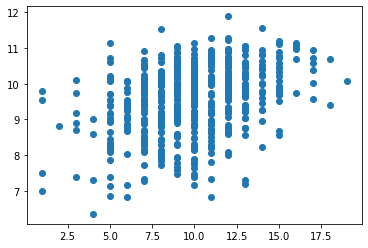

R2:  0.11767757689754832
Performance on test set using optimal number of columns: 
WISC,WISC_SS_Scaled
r2:  0.06832313504496323


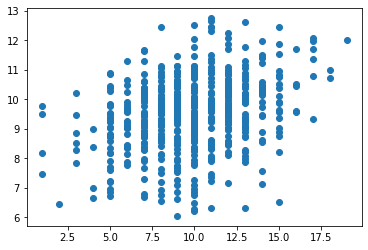

R2:  0.06832313504496323
Performance on test set using number of columns with maximum score
WISC,WISC_SS_Scaled
r2:  0.100380599062597


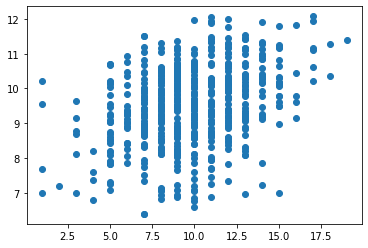

R2:  0.100380599062597


In [14]:
# Print sfs results
for output in output_cols:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimator, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])